## Project Description

The Strimchik online store sells computer games all over the world. Historical game sales data, user and expert ratings, genres and platforms (such as Xbox or PlayStation) are available from public sources. It is necessary to identify patterns that determine the success of the game. This will allow you to bid on a potentially popular product and plan advertising campaigns.

Data provided up to 2016. Let's say it's December 2016 and we're planning a campaign for 2017. It is necessary to work out the principle of working with data.

The abbreviation ESRB (Entertainment Software Rating Board) comes across in the data set - this is an association that determines the age rating of computer games. The ESRB evaluates game content and assigns it to an appropriate age rating, such as Mature, Toddler, or Teen.

## Data exploration

In [1]:
# Import libraries
import pandas as pd
import datetime as dt
import numpy as np
import math
from matplotlib import pyplot as plt
from scipy import stats as st

In [2]:
# Read file into dataframe
games_data = pd.read_csv('games.csv')

In [3]:
# Get information about the dataframe
games_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [4]:
# Look at the structure of the dataframe
games_data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [5]:
# Find out the number of gaps in columns
games_data.isna().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64

In [6]:
# Find out the number of duplicates by dataframe
games_data.duplicated().sum()

0

## Data preparation

### Converting column names to common case

In [7]:
# Convert the data to lowercase and check the result
games_data.columns = games_data.columns.str.lower()
games_data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

### Сonvert the data to the required types

According to the information about the data and its presentation, it is necessary to cast the two columns `year_of_release` and `user_score`.
`year_of_release` to int and `user_score` to float.

In [8]:
# Float in years column due to NaN
games_data['year_of_release'].sort_values().unique()

array([1980., 1981., 1982., 1983., 1984., 1985., 1986., 1987., 1988.,
       1989., 1990., 1991., 1992., 1993., 1994., 1995., 1996., 1997.,
       1998., 1999., 2000., 2001., 2002., 2003., 2004., 2005., 2006.,
       2007., 2008., 2009., 2010., 2011., 2012., 2013., 2014., 2015.,
       2016.,   nan])

In [9]:
# Replace NaN with -999 to be able to cast the column to int without losing those gaps
games_data['year_of_release'] = games_data['year_of_release'].fillna(-999)

In [10]:
# Object in score column due to unknown "tbd", NaN also present
games_data['user_score'].sort_values().unique()

array(['0', '0.2', '0.3', '0.5', '0.6', '0.7', '0.9', '1', '1.1', '1.2',
       '1.3', '1.4', '1.5', '1.6', '1.7', '1.8', '1.9', '2', '2.1', '2.2',
       '2.3', '2.4', '2.5', '2.6', '2.7', '2.8', '2.9', '3', '3.1', '3.2',
       '3.3', '3.4', '3.5', '3.6', '3.7', '3.8', '3.9', '4', '4.1', '4.2',
       '4.3', '4.4', '4.5', '4.6', '4.7', '4.8', '4.9', '5', '5.1', '5.2',
       '5.3', '5.4', '5.5', '5.6', '5.7', '5.8', '5.9', '6', '6.1', '6.2',
       '6.3', '6.4', '6.5', '6.6', '6.7', '6.8', '6.9', '7', '7.1', '7.2',
       '7.3', '7.4', '7.5', '7.6', '7.7', '7.8', '7.9', '8', '8.1', '8.2',
       '8.3', '8.4', '8.5', '8.6', '8.7', '8.8', '8.9', '9', '9.1', '9.2',
       '9.3', '9.4', '9.5', '9.6', '9.7', 'tbd', nan], dtype=object)

In [11]:
# 'tbd' is To Be Determined to be determined / decision to be made
# At this stage, it corresponds to the absence of values, so it can be replaced with NaN
games_data.loc[games_data['user_score'] == 'tbd', 'user_score'] = np.nan
games_data['user_score'].sort_values().unique()

array(['0', '0.2', '0.3', '0.5', '0.6', '0.7', '0.9', '1', '1.1', '1.2',
       '1.3', '1.4', '1.5', '1.6', '1.7', '1.8', '1.9', '2', '2.1', '2.2',
       '2.3', '2.4', '2.5', '2.6', '2.7', '2.8', '2.9', '3', '3.1', '3.2',
       '3.3', '3.4', '3.5', '3.6', '3.7', '3.8', '3.9', '4', '4.1', '4.2',
       '4.3', '4.4', '4.5', '4.6', '4.7', '4.8', '4.9', '5', '5.1', '5.2',
       '5.3', '5.4', '5.5', '5.6', '5.7', '5.8', '5.9', '6', '6.1', '6.2',
       '6.3', '6.4', '6.5', '6.6', '6.7', '6.8', '6.9', '7', '7.1', '7.2',
       '7.3', '7.4', '7.5', '7.6', '7.7', '7.8', '7.9', '8', '8.1', '8.2',
       '8.3', '8.4', '8.5', '8.6', '8.7', '8.8', '8.9', '9', '9.1', '9.2',
       '9.3', '9.4', '9.5', '9.6', '9.7', nan], dtype=object)

In [12]:
# Cast the selected columns to the desired type and check the result
games_data['year_of_release'] = games_data['year_of_release'].astype(int)
games_data['user_score'] = games_data['user_score'].astype(float)
games_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16715 non-null  int32  
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   object 
dtypes: float64(6), int32(1), object(4)
memory usage: 1.3+ MB


### Pass processing

In [13]:
# Check for gaps in the 'name' column
games_data[games_data['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


In [14]:
# The resulting rows with missing names will not help us in the study, these data can be excluded
games_data = games_data[~games_data.name.isnull()]

In [15]:
# We also got rid of gaps in the 'genre' column
games_data.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8576
user_score         9123
rating             6764
dtype: int64

Leave the gaps in the scores as they are. Since filling them in may affect the final result.
The gaps in the year column were left as is at the stage of casting to the data type.

Gaps in the data could appear due to technical reasons, the obsolescence of the game and the weakening of interest in it, the lack of sufficient feedback to obtain a final score.

### Calculation of total sales

In [16]:
# Function for calculating total sales
def sales_sum(row):
    
    na = row['na_sales']
    eu = row['eu_sales']
    jp = row['jp_sales']
    other = row['other_sales']
    sum = na + eu + jp + other
    return sum
    
games_data['sum_sales'] = games_data.apply(sales_sum, axis=1)
games_data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


## Exploratory data analysis

### Number of games released in different years

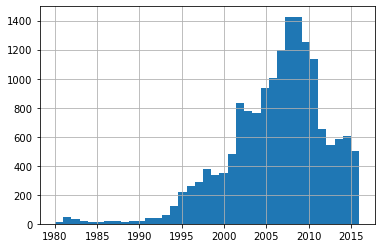

In [17]:
# Let's see how many games were released in different years
games_data['year_of_release'].hist(bins=37, range=(1980, 2016));

As can be seen from the histogram, the main release of games falls from 2002 to 2015.

### Sales by platform

In [18]:
# Determine the platforms with the highest sales
platforms = games_data.groupby('platform')['sum_sales'].sum().sort_values(ascending=False)
platforms

platform
PS2     1255.77
X360     971.42
PS3      939.65
Wii      907.51
DS       806.12
PS       730.86
GBA      317.85
PS4      314.14
PSP      294.05
PC       259.52
3DS      259.00
XB       257.74
GB       255.46
NES      251.05
N64      218.68
SNES     200.04
GC       198.93
XOne     159.32
2600      96.98
WiiU      82.19
PSV       54.07
SAT       33.59
GEN       28.35
DC        15.95
SCD        1.86
NG         1.44
WS         1.42
TG16       0.16
3DO        0.10
GG         0.04
PCFX       0.03
Name: sum_sales, dtype: float64

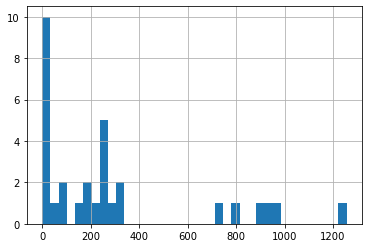

In [19]:
platforms.hist(bins=37);

In [20]:
top_platforms = games_data.groupby('platform')['sum_sales'].sum().sort_values(ascending=False).head(6)
top_platforms

platform
PS2     1255.77
X360     971.42
PS3      939.65
Wii      907.51
DS       806.12
PS       730.86
Name: sum_sales, dtype: float64

As you can see, the most sold are `PS2` `X360` `Wii` `PS3` `DS` `PC`. Thus, we will build the distribution by years for these platforms.

### Sales leaders

Previously, the top 6 by sales were determined, let's build histograms by year to determine the characteristic period for platforms

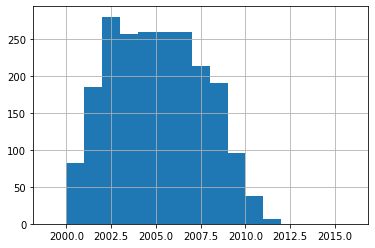

In [21]:
# Build distribution by year for PS2
games_data[games_data['platform'] == 'PS2']['year_of_release'].hist(bins=17, range=(1999, 2016));

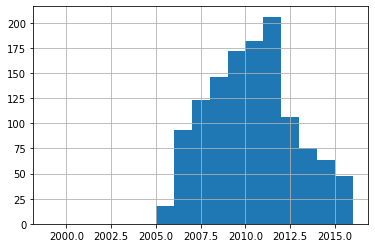

In [22]:
# Build the distribution by years for X360
games_data[games_data['platform'] == 'X360']['year_of_release'].hist(bins=17, range=(1999, 2016));

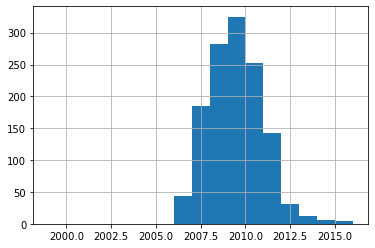

In [23]:
# Build distribution by years for Wii
games_data[games_data['platform'] == 'Wii']['year_of_release'].hist(bins=17, range=(1999, 2016));

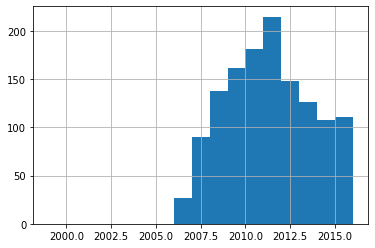

In [24]:
# Build distribution by year for PS3
games_data[games_data['platform'] == 'PS3']['year_of_release'].hist(bins=17, range=(1999, 2016));

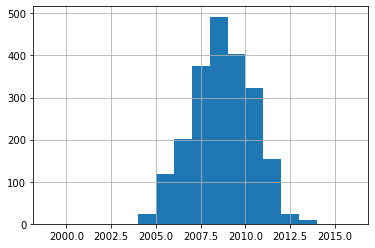

In [25]:
# Build the distribution by years for DS
games_data[games_data['platform'] == 'DS']['year_of_release'].hist(bins=17, range=(1999, 2016));

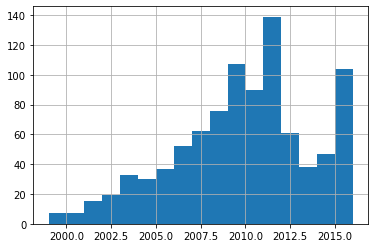

In [26]:
# Build the distribution by year for PC
games_data[games_data['platform'] == 'PC']['year_of_release'].hist(bins=17, range=(1999, 2016));

As you can see, the characteristic period for platforms is approximately 5 to 7 years.
Separately, it is worth noting `PC` for which it is impossible to select the current period, since according to the graphs, the number of games is almost constantly growing.
We choose the current period for the study from 2015 to 2016.

Let's build for the remaining platforms that have data from 2015 to 2016.

### Growth / fall of platforms for the current period

Previously, the actual period for platforms was determined - 3 years. Let's build for platforms that meet this condition.

In [27]:
# Create a dataframe from the original, for the selected time period
games_data_relevant = games_data[games_data['year_of_release'] >= 2014]

The most profitable platforms have already been discussed above. Of these, `X360`, `PC` and `PS3` more or less bring income, the rest of the platforms somehow ceased to bring profit.

Now let's look at the remaining platforms to determine their rise / fall.

In [28]:
# Evaluate the top sales for the current period
platforms_relevant = games_data_relevant.groupby('platform')['sum_sales'].sum().sort_values(ascending=False)
platforms_relevant

platform
PS4     288.15
XOne    140.36
3DS      86.68
PS3      68.18
X360     48.22
WiiU     42.98
PC       27.05
PSV      22.40
Wii       5.07
PSP       0.36
Name: sum_sales, dtype: float64

As you can see, the picture has changed somewhat compared to the original dataframe.
For example games on `PC` became noticeably less.

Next, we normalize the data by the number of games that dropped out of the relevant period of time. This will help us weed out platforms that are no longer relevant.

In [29]:
# Define a normalization, sort it in descending order, and output the resulting values.
normalization = (platforms - platforms_relevant) / platforms
normalization = normalization.dropna().sort_values(ascending=True)
normalization

platform
PS4     0.082734
XOne    0.119006
WiiU    0.477065
PSV     0.585722
3DS     0.665328
PC      0.895769
PS3     0.927441
X360    0.950361
Wii     0.994413
PSP     0.998776
Name: sum_sales, dtype: float64

Thus, the `Wii` `DS` `PSP` platforms are in decline. They will not be presented in further diagrams.

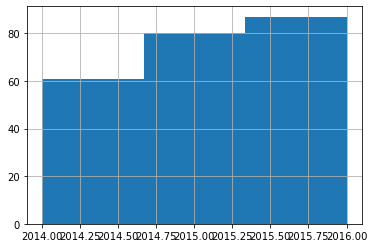

In [30]:
games_data_relevant[games_data_relevant['platform'] == 'XOne']['year_of_release'].hist(bins=3, range=(2014, 2016));

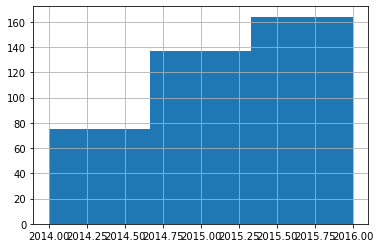

In [31]:
games_data_relevant[games_data_relevant['platform'] == 'PS4']['year_of_release'].hist(bins=3, range=(2014, 2016));

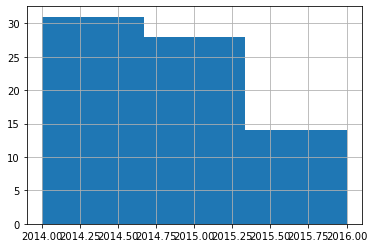

In [32]:
games_data_relevant[games_data_relevant['platform'] == 'WiiU']['year_of_release'].hist(bins=3, range=(2014, 2016));

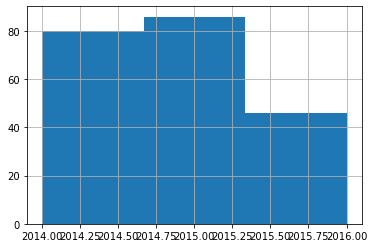

In [33]:
games_data_relevant[games_data_relevant['platform'] == '3DS']['year_of_release'].hist(bins=3, range=(2014, 2016));

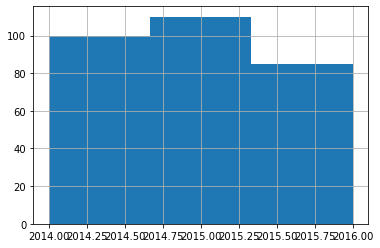

In [34]:
games_data_relevant[games_data_relevant['platform'] == 'PSV']['year_of_release'].hist(bins=3, range=(2014, 2016));

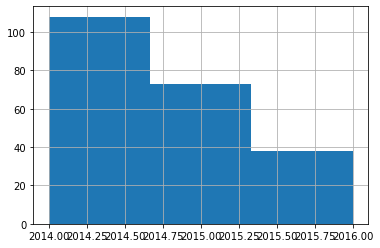

In [35]:
games_data_relevant[games_data_relevant['platform'] == 'PS3']['year_of_release'].hist(bins=3, range=(2014, 2016));

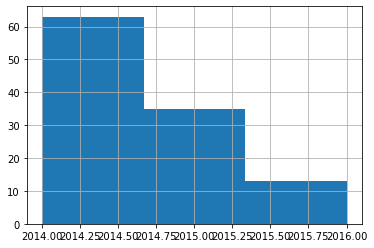

In [36]:
games_data_relevant[games_data_relevant['platform'] == 'X360']['year_of_release'].hist(bins=3, range=(2014, 2016));

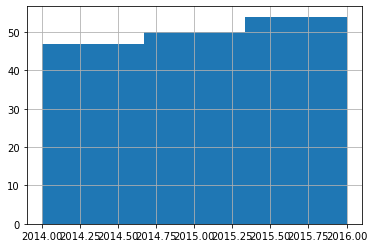

In [37]:
games_data_relevant[games_data_relevant['platform'] == 'PC']['year_of_release'].hist(bins=3, range=(2014, 2016));

So, as you can see from the graphs, the `XOne` and `PS4` platforms are growing. Platforms `PC` and `PSV` show stable results. All other platforms are in decline.

Thus, the most profitable platforms are likely to be `XOne` and `PS4`.

### Global sales charts by platform

Let's build range diagrams for the platforms we are interested in.

(-0.721, 15.360999999999999)

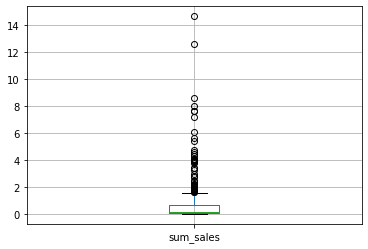

In [38]:
# For PS4
PS4 = games_data_relevant[games_data_relevant['platform'] == 'PS4']
PS4.boxplot(column="sum_sales");
plt.ylim()

(-0.359, 7.758999999999999)

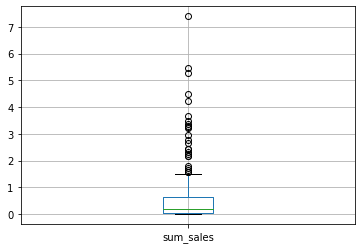

In [39]:
# For XOne
XOne = games_data_relevant[games_data_relevant['platform'] == 'XOne']
XOne.boxplot(column="sum_sales");
plt.ylim()

(-0.34400000000000003, 7.444)

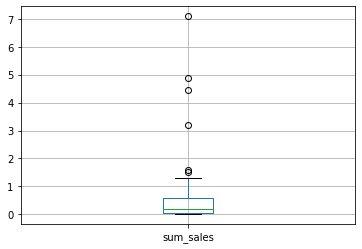

In [40]:
# For WiiU
WiiU = games_data_relevant[games_data_relevant['platform'] == 'WiiU']
WiiU.boxplot(column="sum_sales");
plt.ylim()

(-0.08750000000000002, 2.0575)

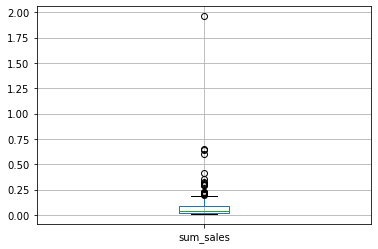

In [41]:
# For PSV
PSV = games_data_relevant[games_data_relevant['platform'] == 'PSV']
PSV.boxplot(column="sum_sales");
plt.ylim()

(-0.5735, 12.2635)

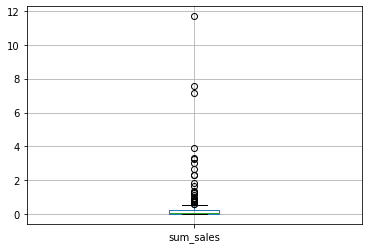

In [42]:
# For 3DS
DS3 = games_data_relevant[games_data_relevant['platform'] == '3DS']
DS3.boxplot(column="sum_sales");
plt.ylim()

(-0.25300000000000006, 5.533)

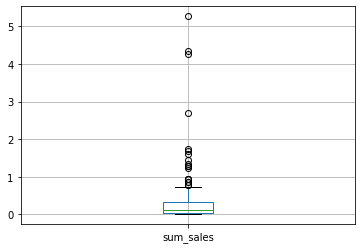

In [43]:
# For PS3
PS3 = games_data_relevant[games_data_relevant['platform'] == 'PS3']
PS3.boxplot(column="sum_sales");
plt.ylim()

(-0.20350000000000001, 4.4935)

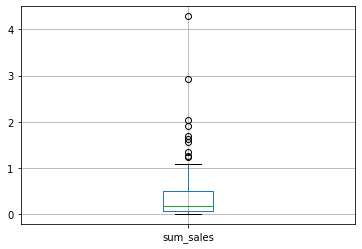

In [44]:
# For X360
X360 = games_data_relevant[games_data_relevant['platform'] == 'X360']
X360.boxplot(column="sum_sales");
plt.ylim()

(-0.14200000000000002, 3.2020000000000004)

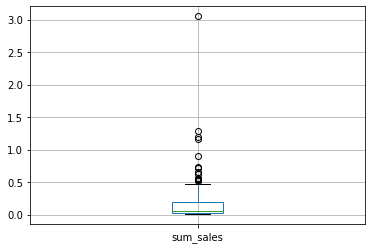

In [45]:
# For PC
PC = games_data_relevant[games_data_relevant['platform'] == 'PC']
PC.boxplot(column="sum_sales");
plt.ylim()

As you can see, the PS3 and PS4 platforms set sales records, the X platforms have a large median, but at the same time do not have such record total sales. Most of the games sold are on the X... and PS... platforms.
Portable set-top boxes are less in demand than stationary ones.

The most popular platform is PS4.

### Impact of Reviews on Sales

Let's take the PS4 platform for evaluation. We construct scatterplots and calculate the Pearson coefficient.

Pearsons correlation coefficient (critics): 0.402661410681041
Pearson correlation coefficient (users): -0.040131589472697286


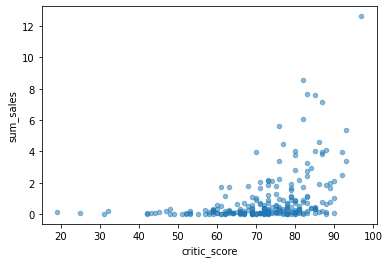

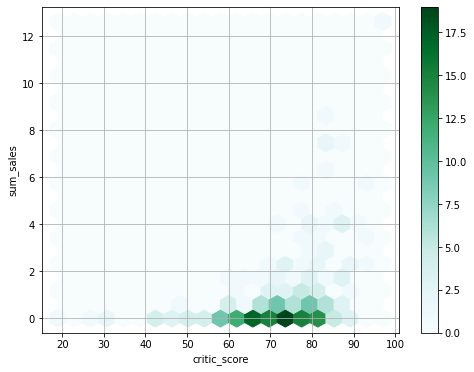

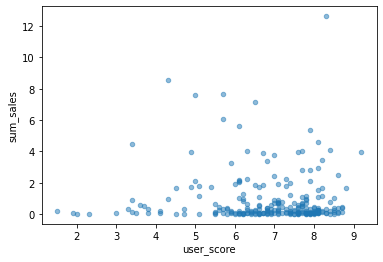

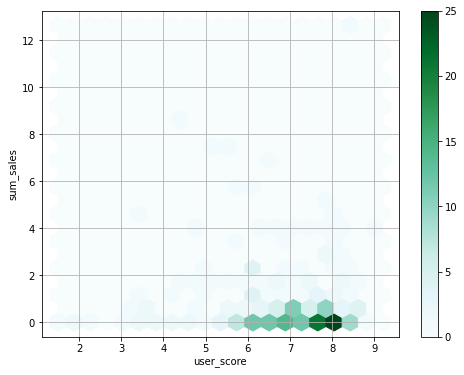

In [46]:
PS4.plot(x='critic_score', y='sum_sales', kind='scatter', alpha=0.5)
PS4.plot(x='critic_score', y='sum_sales', kind='hexbin', gridsize=20, figsize=(8, 6), sharex=False, grid=True) 
print('Pearsons correlation coefficient (critics):', PS4['sum_sales'].corr(PS4['critic_score']))

PS4.plot(x='user_score', y='sum_sales', kind='scatter', alpha=0.5)
PS4.plot(x='user_score', y='sum_sales', kind='hexbin', gridsize=20, figsize=(8, 6), sharex=False, grid=True) 
print('Pearson correlation coefficient (users):', PS4['sum_sales'].corr(PS4['user_score']))

According to the evaluation results, there is a weak direct relationship between the number of sales and the rating of critics.
There is no dependence on user ratings.

Do the same for XOne

Pearsons correlation coefficient (critics): 0.428676943703332
Pearson correlation coefficient (users): -0.07038392806475818


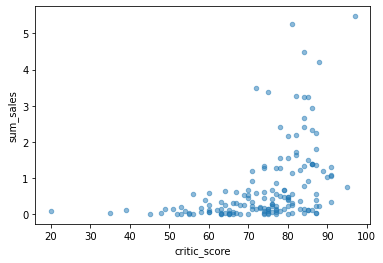

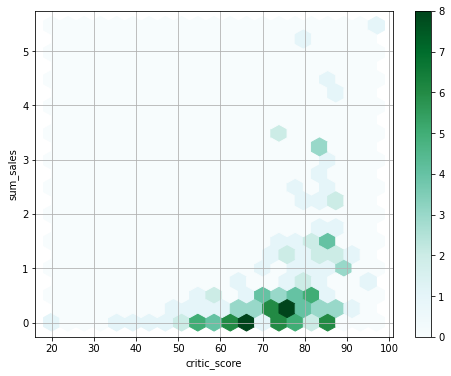

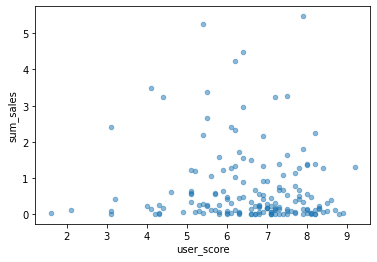

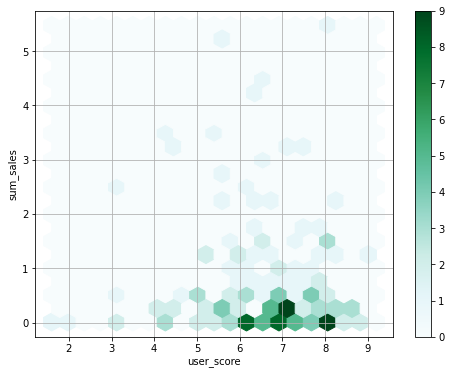

In [47]:
XOne.plot(x='critic_score', y='sum_sales', kind='scatter', alpha=0.5)
XOne.plot(x='critic_score', y='sum_sales', kind='hexbin', gridsize=20, figsize=(8, 6), sharex=False, grid=True) 
print('Pearsons correlation coefficient (critics):', XOne['sum_sales'].corr(XOne['critic_score']))

XOne.plot(x='user_score', y='sum_sales', kind='scatter', alpha=0.5)
XOne.plot(x='user_score', y='sum_sales', kind='hexbin', gridsize=20, figsize=(8, 6), sharex=False, grid=True) 
print('Pearson correlation coefficient (users):', XOne['sum_sales'].corr(XOne['user_score']))

Для PC

Pearsons correlation coefficient (critics): 0.17463413769350025
Pearson correlation coefficient (users): -0.07159665703472454


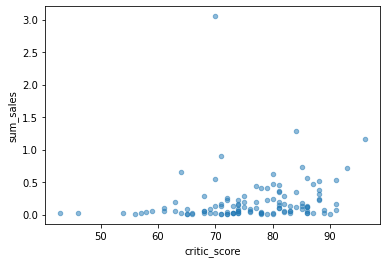

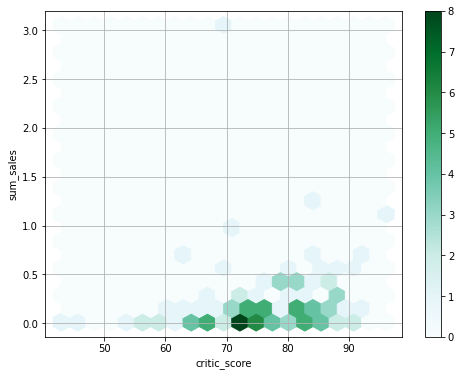

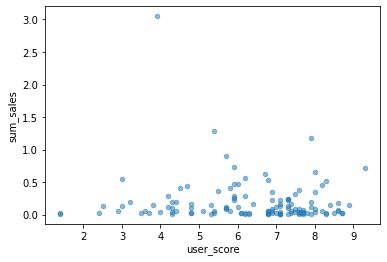

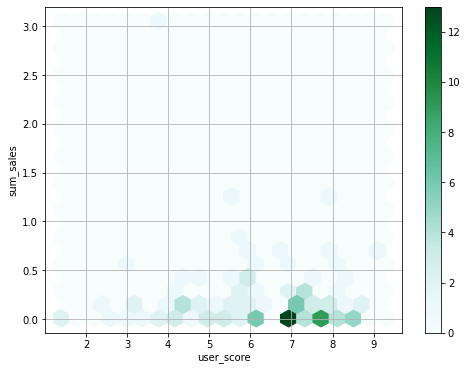

In [48]:
PC.plot(x='critic_score', y='sum_sales', kind='scatter', alpha=0.5)
PC.plot(x='critic_score', y='sum_sales', kind='hexbin', gridsize=20, figsize=(8, 6), sharex=False, grid=True) 
print('Pearsons correlation coefficient (critics):', PC['sum_sales'].corr(PC['critic_score']))

PC.plot(x='user_score', y='sum_sales', kind='scatter', alpha=0.5)
PC.plot(x='user_score', y='sum_sales', kind='hexbin', gridsize=20, figsize=(8, 6), sharex=False, grid=True) 
print('Pearson correlation coefficient (users):', PC['sum_sales'].corr(PC['user_score']))

Для PS3

Pearsons correlation coefficient (critics): 0.44657460493190715
Pearson correlation coefficient (users): -0.16676141347662105


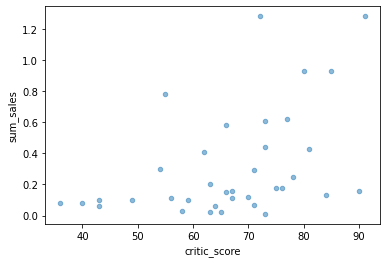

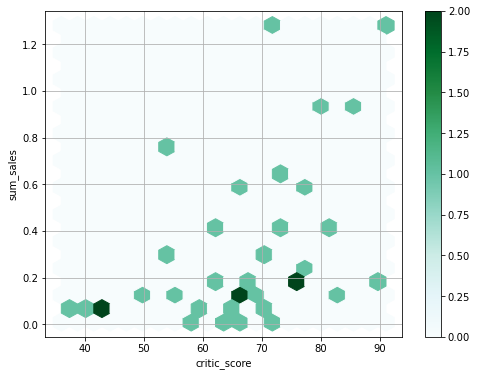

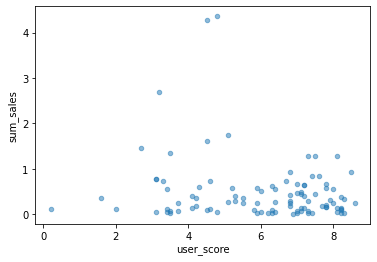

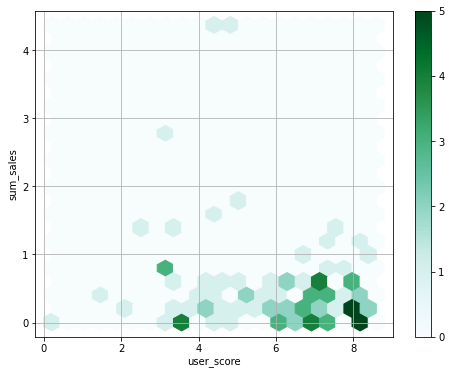

In [49]:
PS3.plot(x='critic_score', y='sum_sales', kind='scatter', alpha=0.5)
PS3.plot(x='critic_score', y='sum_sales', kind='hexbin', gridsize=20, figsize=(8, 6), sharex=False, grid=True) 
print('Pearsons correlation coefficient (critics):', PS3['sum_sales'].corr(PS3['critic_score']))

PS3.plot(x='user_score', y='sum_sales', kind='scatter', alpha=0.5)
PS3.plot(x='user_score', y='sum_sales', kind='hexbin', gridsize=20, figsize=(8, 6), sharex=False, grid=True) 
print('Pearson correlation coefficient (users):', PS3['sum_sales'].corr(PS3['user_score'])) 

Для X360

Pearsons correlation coefficient (critics): 0.5257228356581521
Pearson correlation coefficient (users): -0.13844457094566506


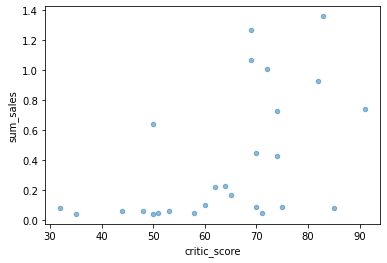

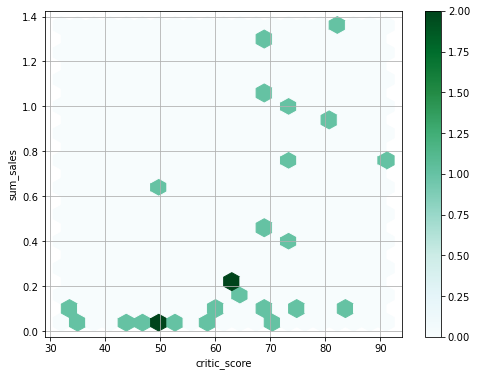

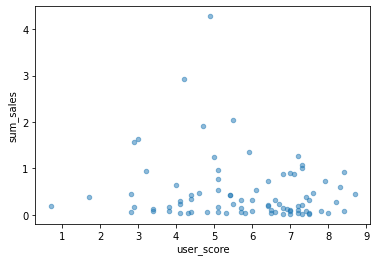

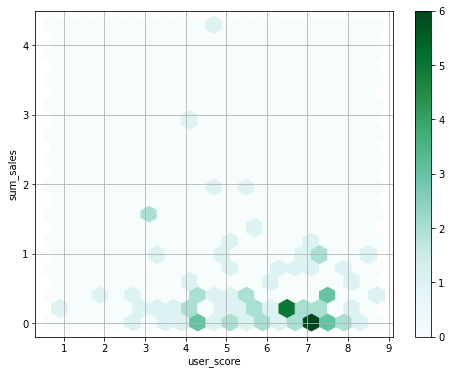

In [50]:
X360.plot(x='critic_score', y='sum_sales', kind='scatter', alpha=0.5)
X360.plot(x='critic_score', y='sum_sales', kind='hexbin', gridsize=20, figsize=(8, 6), sharex=False, grid=True) 
print('Pearsons correlation coefficient (critics):', X360['sum_sales'].corr(X360['critic_score']))

X360.plot(x='user_score', y='sum_sales', kind='scatter', alpha=0.5)
X360.plot(x='user_score', y='sum_sales', kind='hexbin', gridsize=20, figsize=(8, 6), sharex=False, grid=True) 
print('Pearson correlation coefficient (users):', X360['sum_sales'].corr(X360['user_score']))

Для WiiU

Pearsons correlation coefficient (critics): 0.37020141248088406
Pearson correlation coefficient (users): 0.40792645792170784


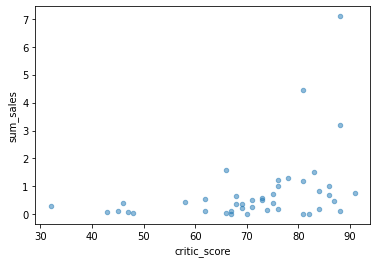

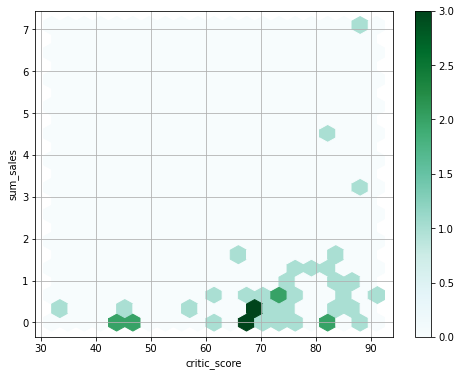

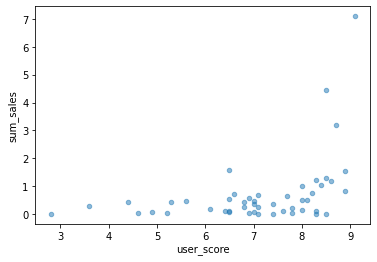

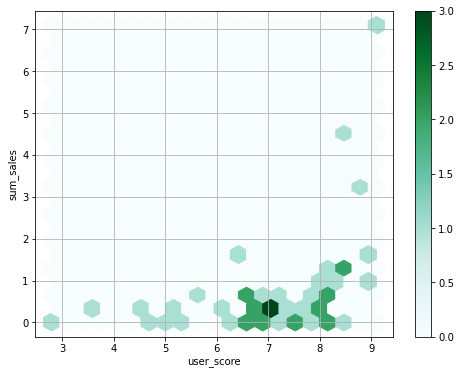

In [51]:
WiiU.plot(x='critic_score', y='sum_sales', kind='scatter', alpha=0.5)
WiiU.plot(x='critic_score', y='sum_sales', kind='hexbin', gridsize=20, figsize=(8, 6), sharex=False, grid=True) 
print('Pearsons correlation coefficient (critics):', WiiU['sum_sales'].corr(WiiU['critic_score']))

WiiU.plot(x='user_score', y='sum_sales', kind='scatter', alpha=0.5)
WiiU.plot(x='user_score', y='sum_sales', kind='hexbin', gridsize=20, figsize=(8, 6), sharex=False, grid=True) 
print('Pearson correlation coefficient (users):', WiiU['sum_sales'].corr(WiiU['user_score']))

Для 3DS

Pearsons correlation coefficient (critics): 0.31411749286905094
Коэффициент корреляции Пирсона (пользователи): 0.2151932718527028


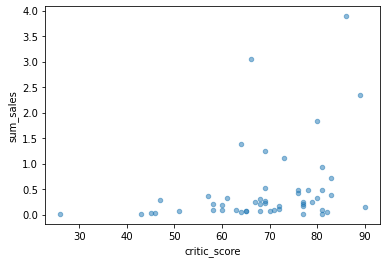

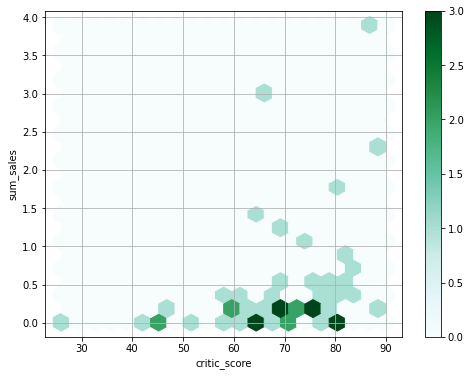

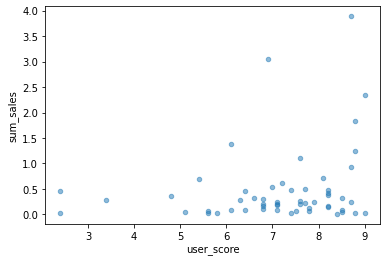

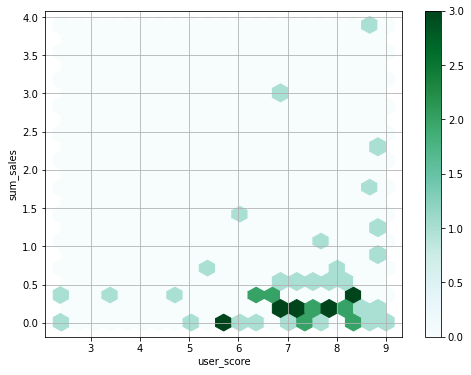

In [52]:
DS3.plot(x='critic_score', y='sum_sales', kind='scatter', alpha=0.5)
DS3.plot(x='critic_score', y='sum_sales', kind='hexbin', gridsize=20, figsize=(8, 6), sharex=False, grid=True) 
print('Pearsons correlation coefficient (critics):', DS3['sum_sales'].corr(DS3['critic_score']))

DS3.plot(x='user_score', y='sum_sales', kind='scatter', alpha=0.5)
DS3.plot(x='user_score', y='sum_sales', kind='hexbin', gridsize=20, figsize=(8, 6), sharex=False, grid=True) 
print('Коэффициент корреляции Пирсона (пользователи):', DS3['sum_sales'].corr(DS3['user_score']))

Для PSV

Pearsons correlation coefficient (critics): 0.04266490657009527
Pearson correlation coefficient (users): -0.16845504978064438


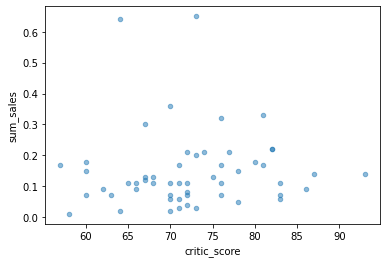

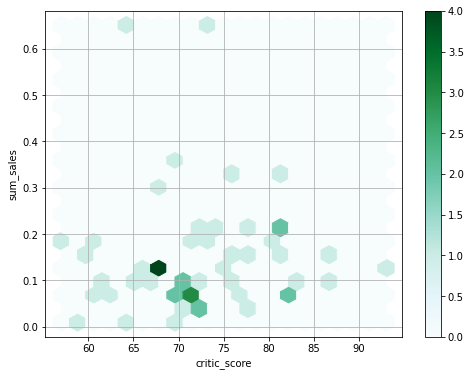

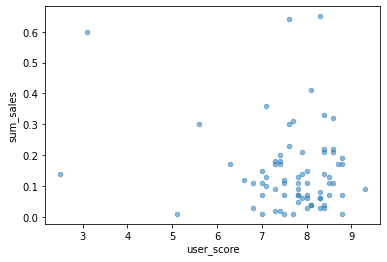

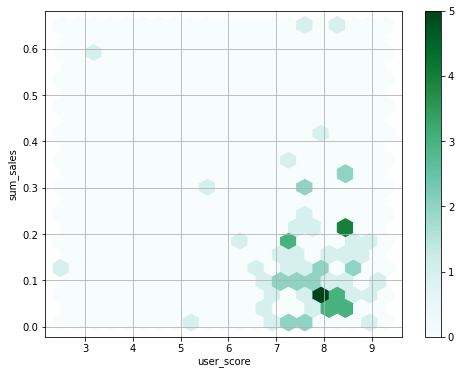

In [53]:
PSV.plot(x='critic_score', y='sum_sales', kind='scatter', alpha=0.5)
PSV.plot(x='critic_score', y='sum_sales', kind='hexbin', gridsize=20, figsize=(8, 6), sharex=False, grid=True) 
print('Pearsons correlation coefficient (critics):', PSV['sum_sales'].corr(PSV['critic_score']))

PSV.plot(x='user_score', y='sum_sales', kind='scatter', alpha=0.5)
PSV.plot(x='user_score', y='sum_sales', kind='hexbin', gridsize=20, figsize=(8, 6), sharex=False, grid=True) 
print('Pearson correlation coefficient (users):', PSV['sum_sales'].corr(PSV['user_score']))

As you can see, there is practically no dependence of sales on user ratings among platforms (except for `WiiU` and `3DS`). There is a direct dependence on the assessment of critics, but not strong enough.

On top platforms, these conclusions are about the same as on others.

### Definition of profitable genres

In [54]:
# Group data by genre and sum sales
genre_sales = games_data_relevant.groupby('genre')['sum_sales'].sum().sort_values(ascending=False)
genre_sales

genre
Action          199.36
Shooter         170.94
Sports          109.48
Role-Playing    101.44
Misc             37.55
Fighting         28.22
Racing           27.52
Platform         18.09
Adventure        17.55
Simulation       13.13
Strategy          3.96
Puzzle            2.21
Name: sum_sales, dtype: float64

Thus, the most profitable genres are `Action`, `Shooter`, `Role-Playing` and `Sports`. And the least profitable `Strategy` and `Puzzle`.

## Drawing up a portrait of the user of each region

### Top 5 most popular platforms

Let's determine the top platforms by region.

In [55]:
# Rename the sales columns in the regions under the names of the regions
games_data_relevant = games_data_relevant.rename(columns={'na_sales' : 'na', 'eu_sales' : 'eu', 'jp_sales' : 'jp'})
# Forming a list for subsequent cycles
reg = ['na', 'eu', 'jp']

for value in reg:
    print(f'Top 5 platforms in {value}:')
    print(games_data_relevant.groupby('platform')[value].sum().sort_values(ascending=False).head())
    print()

Top 5 platforms in na:
platform
PS4     98.61
XOne    81.27
X360    28.30
3DS     22.64
PS3     22.05
Name: na, dtype: float64

Top 5 platforms in eu:
platform
PS4     130.04
XOne     46.25
PS3      25.54
PC       17.97
3DS      16.12
Name: eu, dtype: float64

Top 5 platforms in jp:
platform
3DS     44.24
PS4     15.02
PSV     14.54
PS3     11.22
WiiU     7.31
Name: jp, dtype: float64



The `jp` region is dominated by handheld consoles, accounting for 70% of sales.

At the same time, the share of sales in the `eu` region for portable platforms is extremely small, and the main market players are `PS3` and `PS4`. They account for 60% of all purchases.

In the `na` region, the share of sales attributable to portable platforms is small. The main platforms in the market are `X360`, `PS4` and `PS3`.

### Тtop 5 most popular genres

Let's define the top genres by region.

In [56]:
for value in reg:
    print(f'Top 5 platforms in {value}:')
    print(games_data_relevant.groupby('genre')[value].sum().sort_values(ascending=False).head())
    print()

Top 5 platforms in na:
genre
Shooter         79.02
Action          72.53
Sports          46.13
Role-Playing    33.47
Misc            15.05
Name: na, dtype: float64

Top 5 platforms in eu:
genre
Action          74.68
Shooter         65.52
Sports          45.73
Role-Playing    28.17
Racing          14.13
Name: eu, dtype: float64

Top 5 platforms in jp:
genre
Role-Playing    31.16
Action          29.58
Fighting         6.37
Misc             5.61
Shooter          4.87
Name: jp, dtype: float64



The `na` and `eu` regions are characterized by the predominance of `Action` and `Shooter`. Also, the difference in the top genres is only in 5 positions. In general, these regions are similar in terms of genre interests.

At the same time, the `jp` region is fundamentally different from them. It has `Role-Playing` and `Action` in the first places. And then the other genres follow by a wide margin.

### The impact of the ESRB on sales in a particular region

In [57]:
# Create a dataframe to work with rating impact assessment
esrb_sales_influence = pd.DataFrame
# Copy the original dataframe and remove unnecessary columns
esrb_sales_influence = games_data_relevant.copy(deep=True)
esrb_sales_influence = esrb_sales_influence.drop(columns=['platform', 
                                                          'year_of_release', 
                                                          'genre', 
                                                          'other_sales',
                                                          'critic_score',
                                                          'user_score',
                                                          'sum_sales'], axis = 1)
# Let's replace NaN in the gaps with None in order to perform the necessary mathematical operations and make the gaps into a separate category
esrb_sales_influence = esrb_sales_influence.fillna('None')
esrb_sales_influence

,name,na,eu,jp,rating
31,Call of Duty: Black Ops 3,6.03,5.86,0.36,None
42,Grand Theft Auto V,3.96,6.31,0.38,M
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,4.35,3.49,3.10,None
77,FIFA 16,1.12,6.12,0.06,E
87,Star Wars Battlefront (2015),2.99,3.49,0.22,None
...,...,...,...,...,...
16703,Strawberry Nauts,0.00,0.00,0.01,None
16707,Aiyoku no Eustia,0.00,0.00,0.01,None
16710,Samurai Warriors: Sanada Maru,0.00,0.00,0.01,None
16712,Haitaka no Psychedelica,0.00,0.00,0.01,None


In [58]:
# Function to calculate the percentage of sales in the region
def sales_rating_na(row):    
    na = row['na']
    eu = row['eu']
    jp = row['jp']
    sum = na + eu + jp 
    return na / sum

def sales_rating_eu(row):    
    na = row['na']
    eu = row['eu']
    jp = row['jp']
    sum = na + eu + jp 
    return eu / sum

def sales_rating_jp(row):    
    na = row['na']
    eu = row['eu']
    jp = row['jp']
    sum = na + eu + jp 
    return jp / sum

# For each game, the percentage of sales by region is calculated
# Accordingly, for each rating, sets of sales percentages will be obtained
esrb_sales_influence['na_%'] = esrb_sales_influence.apply(sales_rating_na, axis=1)
esrb_sales_influence['eu_%'] = esrb_sales_influence.apply(sales_rating_eu, axis=1)
esrb_sales_influence['jp_%'] = esrb_sales_influence.apply(sales_rating_jp, axis=1)
esrb_sales_influence

,name,na,eu,jp,rating,na_%,eu_%,jp_%
31,Call of Duty: Black Ops 3,6.03,5.86,0.36,None,0.492245,0.478367,0.029388
42,Grand Theft Auto V,3.96,6.31,0.38,M,0.371831,0.592488,0.035681
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,4.35,3.49,3.10,None,0.397623,0.319013,0.283364
77,FIFA 16,1.12,6.12,0.06,E,0.153425,0.838356,0.008219
87,Star Wars Battlefront (2015),2.99,3.49,0.22,None,0.446269,0.520896,0.032836
...,...,...,...,...,...,...,...,...
16703,Strawberry Nauts,0.00,0.00,0.01,None,0.000000,0.000000,1.000000
16707,Aiyoku no Eustia,0.00,0.00,0.01,None,0.000000,0.000000,1.000000
16710,Samurai Warriors: Sanada Maru,0.00,0.00,0.01,None,0.000000,0.000000,1.000000
16712,Haitaka no Psychedelica,0.00,0.00,0.01,None,0.000000,0.000000,1.000000


In [59]:
# Group all percentages for each region, and then normalize them by the number of games with a particular rating
# Thus, we get the percentage of sales of games that have been assigned this or that rating
print('Percentage of sales for NA by ratings:')
esrb_sales_influence.groupby('rating')['na_%'].sum() / esrb_sales_influence.groupby('rating')['na_%'].count()

Percentage of sales for NA by ratings:


rating
E       0.387099
E10+    0.469302
M       0.468432
None    0.166488
T       0.360865
Name: na_%, dtype: float64

In [60]:
print('Percentage of sales for EU by ratings:')
esrb_sales_influence.groupby('rating')['eu_%'].sum() / esrb_sales_influence.groupby('rating')['na_%'].count()

Percentage of sales for EU by ratings:


rating
E       0.556118
E10+    0.462724
M       0.458486
None    0.211169
T       0.358320
dtype: float64

In [61]:
print('Percentage of sales for JP by ratings:')
esrb_sales_influence.groupby('rating')['jp_%'].sum() / esrb_sales_influence.groupby('rating')['na_%'].count()

Percentage of sales for JP by ratings:


rating
E       0.056783
E10+    0.067974
M       0.073082
None    0.622343
T       0.280815
dtype: float64

So, as you can see from the percentage of sales, there is some influence of the ranking on sales in different regions:
    
     1. `JP` has the highest number of game sales that have not been assigned an ESRB. The second place is rated "T".
     2. In `EU` region, the highest sales fall on the "E" rating. The following "E10+" and "M" are slightly less popular.
     3. In `NA` segment, unrated games are least preferred. The rest of the rating groups are equally distributed.

## Hypothesis testing

### The average user ratings of the Xbox One and PC platforms are the same

Let's calculate the Mean, variance and standard deviation for user ratings. Then we visualize the distribution and test the hypothesis.

In [62]:
# Mean
mean_user_score_PC = (PC['user_score'].mean())
mean_user_score_X360 = (X360['user_score'].mean())

# Dispersion
dis_user_score_PC = (np.var(PC['user_score']))
dis_user_score_X360 = (np.var(X360['user_score']))

# Standard deviation 
stdev_user_score_PC = (np.std(PC['user_score']))
stdev_user_score_X360 = (np.std(X360['user_score']))

print('Average user rating for PC:', mean_user_score_PC)
print('Average user rating for X360:', mean_user_score_X360)

print('PC User Score Variance:', dis_user_score_PC)
print('Dispersion of user rating for X360:', dis_user_score_X360)

print('Standard deviation of user rating for PC:', stdev_user_score_PC)
print('Standard deviation of user rating for X360:', stdev_user_score_X360)

Average user rating for PC: 6.298360655737703
Average user rating for X360: 5.7710843373493965
PC User Score Variance: 2.877374361730719
Dispersion of user rating for X360: 2.887597619393235
Standard deviation of user rating for PC: 1.6962825123577496
Standard deviation of user rating for X360: 1.6992932705666892


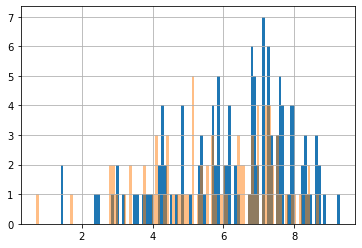

In [63]:
PC['user_score'].hist(bins=100)
X360['user_score'].hist(bins=100, alpha=0.5);

Let's form hypotheses:
    
     1. Null Hypothesis: Average scores of PC and X360 users are equal.
     2. Alternative hypothesis: PC and X360 user average scores are different.


In [64]:
# Check for equality averages
alpha = 0.01 # critical level of statistical significance

# Assume that the population variances are equal
results = st.ttest_ind(PC['user_score'].dropna(), X360['user_score'].dropna(), equal_var = True)

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print("Rejecting the null hypothesis")
else:
    print("Failed to reject the null hypothesis")

p-value: 0.030983578725445982
Failed to reject the null hypothesis


The hypothesis about equal average ratings of `PC` and `X360` was confirmed.

### Average user ratings for the Action and Sports genres are different

In [65]:
action_genre = games_data_relevant[games_data_relevant['genre'] == 'Action']
sports_genre = games_data_relevant[games_data_relevant['genre'] == 'Sports']

In [66]:
# Mean
mean_user_score_action = (action_genre['user_score'].mean())
mean_user_score_sports = (sports_genre['user_score'].mean())

# Dispersion 
dis_user_score_action = (np.var(action_genre['user_score']))
dis_user_score_sports = (np.var(sports_genre['user_score']))

# Standard deviation 
stdev_user_score_action = (np.std(action_genre['user_score']))
stdev_user_score_sports = (np.std(sports_genre['user_score']))

print('Average user rating for genre "Action":', mean_user_score_action)
print('Average user rating for genre "Spotrs":', mean_user_score_sports)

print('Genre User Score Variance "Action":', dis_user_score_action)
print('Genre User Score Variance "Spotrs":', dis_user_score_sports)

print('Standard deviation of the user rating for the genre "Action":', stdev_user_score_action)
print('Standard deviation of the user rating for the genre "Spotrs":', stdev_user_score_sports)

Average user rating for genre "Action": 6.760606060606054
Average user rating for genre "Spotrs": 5.225196850393697
Genre User Score Variance "Action": 1.8920844811753907
Genre User Score Variance "Spotrs": 3.419837559675118
Standard deviation of the user rating for the genre "Action": 1.3755306180435936
Standard deviation of the user rating for the genre "Spotrs": 1.8492802815352567


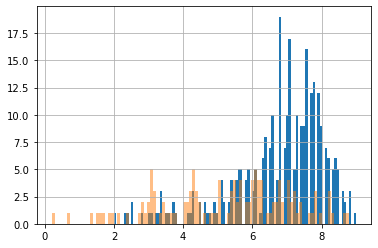

In [67]:
action_genre['user_score'].hist(bins=100)
sports_genre['user_score'].hist(bins=100, alpha=0.5);

Let's form hypotheses:
    
     1. Null hypothesis: the average user rating of the "Action" genre and the "Spotrs" genre are equal.
     2. Alternative hypothesis: the average rating of users of the "Action" genre and the "Spotrs" genre are different.

In [68]:
# Check for equality averages
alpha = 0.01 # critical level of statistical significance

# Assume that the population variances are equal
results = st.ttest_ind(action_genre['user_score'].dropna(), sports_genre['user_score'].dropna(), equal_var = True)

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print("Rejecting the null hypothesis")
else:
    print("Failed to reject the null hypothesis")

p-value: 2.8711147985105864e-19
Rejecting the null hypothesis


The hypothesis about different average ratings of `Action` and `Sports` was confirmed.

## Conclusion

In the course of this work, an analysis was made of the market of gaming platforms in the period from 1980 to 2016. An actual period has been determined on the basis of which forecasts for 2017 can be made.

Top selling platforms identified, as well as potentially profitable and declining platforms. The relationship between the number of sales and the ratings of critics and players was evaluated. The most profitable genres and the genres with the least popularity are determined.

User portraits for three regions were also compiled. For each region, its top platforms, genres and the influence of the rating on sales are determined.

The hypotheses about "average user ratings of `PC` and `X360` platforms" and "average user ratings of `Action` and `Sports`" were tested.